Links:
- [imports](#imports)
- [investigate one wearable](#one_wearable)
- [Read and Sleep Detector](#read_and_sleep_detector)
- [Physical Activity](#physical_activity)
- [Demographics](#demographics)
- [Sequence Length Distribution](#sequence_length)


# Imports <a id='imports'></a>

In [15]:
%matplotlib inline

In [16]:
import time
import functools
import sys
import pandas as pd
import numpy as np
from glob import glob
from hypnospy import Wearable, Experiment, Demographics
from hypnospy.data import MESAPreProcessing, HCHSPreProcessing
from hypnospy.analysis import NonWearingDetector, SleepBoudaryDetector, Viewer, PhysicalActivity, Validator, \
    CircadianAnalysis
from hypnospy.analysis import SleepMetrics, SleepWakeAnalysis

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


def setup_experiment(preprocessor, file_path, start_hour):
    # Configure an Experiment
    exp = Experiment()

    # Iterates over a set of files in a directory.
    # Unfortunately, we have to do it manually with RawProcessing because we are modifying the annotations
    for file in tqdm(glob(file_path)):

        pp = preprocessor(file)
        w = Wearable(pp)  # Creates a wearable from a pp object
        # Invert the two_stages flag. Now True means sleeping and False means awake

        w.data["interval_sleep"] = w.data["interval"].isin(["REST-S", "REST"])
        w.data["sleep"] = ~w.data["wake"].astype(bool)

        exp.add_wearable(w)
        exp.set_freq_in_secs(30)
        w.change_start_hour_for_experiment_day(start_hour)

    return exp

def check_time(t):
    now = time.process_time()
    print("Elapsed %.1f sec (=%.2f min):" % (now - t, (now - t)/60))
    return now



# Read and Sleep Detector <a id='read_and_sleep_detector'></a>

In [64]:

# options are: HCHS_SMALL, A_SMALL, HCHS, MESA
DATA_COLLECTION = "HCHS_SMALL" # sys.argv[1]
DATA_COLLECTION = "MESA"

if DATA_COLLECTION == "MESA_SMALL":
    file_path = "HypnosPy/data/small_collection_mesa/*.csv"

elif DATA_COLLECTION == "MESA":
    file_path = "HypnosPy/data/collection_mesa_actigraphy/*.csv"

elif DATA_COLLECTION == "HCHS_SMALL":
    file_path = "HypnosPy/data/small_collection_hchs/*.csv"

elif DATA_COLLECTION == "HCHS":
    file_path = "HypnosPy/data/collection_hchs_actigraphy/*.csv"

if DATA_COLLECTION in ["MESA", "MESA_SMALL"]:
    preprocessor = MESAPreProcessing
    pid_col = "mesaid"
    path_to_demographics = "HypnosPy/data/demographics/mesa-sleep-dataset-0.3.0.csv"
    variables = ['race1c', 'gender1', 'sleepage5c', 'wkendsleepdur5t', 'nap5', 'trbleslpng5', 'wakeup5',
                 'wakeearly5', 'bcksleep5', 'slpngpills5', 'irritable5', 'sleepy5', 'typicalslp5', 'readng5',
                 'tv5', 'sittng5', 'riding5', 'lyngdwn5', 'talkng5', 'quietly5', 'car5', 'dinner5', 'driving5',
                 'snored5', 'stpbrthng5', 'legsdscmfrt5', 'rubbnglgs5', 'wrserest5', 'wrseltr5', 'feelngbstr5',
                 'tired5', 'mosttired4', 'feelngbstpk5', 'types5', 'slpapnea5', 'cpap5', 'dntaldv5', 'uvula5',
                 'insmnia5', 'rstlesslgs5', 'wrksched5', 'extrahrs5', 'whiirs5c', 'epslpscl5c', 'hoostmeq5c']
    clock_variables = None

elif DATA_COLLECTION in ["HCHS", "HCHS_SMALL"]:
    preprocessor = HCHSPreProcessing
    pid_col = "PID"
    path_to_demographics = "HypnosPy/data/demographics/hchs-dataset-0.5.0-merged.csv"
    variables = ['FLAG_NARC', 'FLAG_AHIGT50', 'FLAG_AGEGE65', "AGE", "GENDERNUM", "AGEGROUP_C2",
                 "AGEGROUP_C2_SUENO", "AGEGROUP_C5_SUENO", "AGEGROUP_C6", "AGEGROUP_C6_NHANES", "AGE_SUENO",
                 "COMMUTEHOME", "COMMUTEWORK", "EDUCATION_C2", "EDUCATION_C3", "EMPLOYED", "INCOME", "INCOME_C3",
                 "INCOME_C5", "MARITAL_STATUS", "N_HC", "OCCUPATION_CURR", "OCCUPATION_LONG", "SHIFT_LENGTH",
                 "SHIFTWORKERYN", "TOTCOMMUTE_DAY", "TOTCOMMUTE_WEEK", "WORK_HRS_DAY", "WORK_HRS_WEEK",
                 "ALCOHOL_USE_DISORDER", "ALCOHOL_USE_LEVEL", "CDCR", "CDCR_SUENO", "CHD_SELF", "CHD_SELF_SUENO",
                 "CIGARETTE_PACK_YEARS", "CIGARETTE_PACK_YEARS_C3", "CIGARETTES_YEAR", "CIGARETTE_USE",
                 "CLAUDICATION_INT", "CURRENT_SMOKER", "CVD_FRAME", "DIAB_DIAG", "DIABETES1", "DIABETES2",
                 "DIABETES2_INDICATOR", "DIABETES3", "DIABETES_C4", "DIABETES_LAB", "DIABETES_SELF",
                 "DIABETES_SELF_SUENO", "DIABETES_SUENO", "DIAB_FAMHIST", "DM_AWARE", "DM_AWARE_SUENO",
                 "DM_CONTROL", "DOCTOR_VISIT", "EVER_ANGINA_RELATIVE", "EVER_CABG_RELATIVE", "EVER_MI_RELATIVE",
                 "EXPOSURE_YEAR", "FH_CHD", "FH_STROKE", "FRAME_CVD_RISK_10YR", "HBA1C_SI", "HOMA_B", "HOMA_IR",
                 "HYPERT_AWARENESS", "HYPERT_CONTROL", "HYPERTENSION", "HYPERTENSION2", "HYPERTENSION_C4",
                 "HYPERTENSION_SUENO", "HYPERT_TREATMENT", "METS_IDF", "METS_NCEP", "METS_NCEP2", "MI_ECG",
                 "PRECHD_ANGINA", "PRECHD_NO_ANGINA", "STROKE", "STROKE_SUENO", "STROKE_TIA", "STROKE_TIA_SUENO",
                 "TOTALDRINKS_PER_WEEK", 'SLEA10', 'SLEA11', 'SLEA12A', 'SLEA12B', 'SLEA12C', 'SLEA12D', 'SLEA12E',
                 'SLEA12F', 'SLEA12G', 'SLEA12H', 'SLEA12I', 'SLEA12J', 'SLEA13', 'SLEA14', 'SLEA15', 'SLEA16',
                 'SLEA17', 'SLEA18', 'SLEA1A_2401', 'SLEA1C_2401', 'SLEA2A_2401', 'SLEA2C_2401', 'SLEA3', 'SLEA4',
                 'SLEA5', 'SLEA6', 'SLEA7', 'SLEA8', 'SLEA9', 'SPEA10', 'SPEA11', 'SPEA12A', 'SPEA12B', 'SPEA12C',
                 'SPEA12D', 'SPEA12E', 'SPEA12F', 'SPEA12G', 'SPEA12H', 'SPEA12I', 'SPEA12J', 'SPEA13', 'SPEA14',
                 'SPEA15', 'SPEA16', 'SPEA17', 'SPEA18', 'SPEA3', 'SPEA4', 'SPEA5', 'SPEA6', 'SPEA7', 'SPEA8',
                 'SPEA9', 'SQEA1', 'SQEA10', 'SQEA11', 'SQEA12', 'SQEA13', 'SQEA14', 'SQEA15', 'SQEA16', 'SQEA17',
                 'SQEA18', 'SQEA19', 'SQEA2', 'SQEA20', 'SQEA21', 'SQEA22', 'SQEA23', 'SQEA24', 'SQEA25', 'SQEA3',
                 'SQEA4', 'SQEA5', 'SQEA6', 'SQEA7', 'SQEA8', 'SQEA9']
    clock_variables = ["SLEA1A_2401", "SLEA1C_2401", "SLEA2A_2401", "SLEA2C_2401"]

start_hour = 15
min_consecutive_days = 5

print("Reading collection from disk...")
start = time.process_time()

exp = setup_experiment(preprocessor, file_path, start_hour)
exp.fill_no_activity(-0.0001)
exp.overall_stats()

elapsed_time = check_time(start)

# TODO: fix bug when annotation_merge_tolerance_in_minutes < 0
print("Sleep Boundary Detector...")
sbd = SleepBoudaryDetector(exp)
sbd.detect_sleep_boundaries(strategy="annotation", output_col="sleep_period_annotation",
                            annotation_col="interval_sleep",
                            annotation_merge_tolerance_in_minutes=120, annotation_only_largest_sleep_period=True)


  0%|                                                                                         | 0/2159 [00:00<?, ?it/s]

Reading collection from disk...


100%|██████████████████████████████████████████████████████████████████████████████| 2159/2159 [08:44<00:00,  4.11it/s]


Total number of wearables: 2159
Total number of days: 19271
Avg. number of days: 8.93 (+-2.261). Max: 20, Min: 4.
Avg. number of epochs: 23574.00 (+-6418.568). Max: 52417, Min: 10314.
Elapsed 442.8 sec (=7.38 min):
Sleep Boundary Detector...


c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for co

# Validation

In [19]:

elapsed_time = check_time(elapsed_time)
print("Validation process...")
va = Validator(exp)
va.flag_epoch_physical_activity_less_than(min_activity_threshold=0)
va.flag_epoch_null_cols(col_list=["hyp_act_x"])

# nwd = NonWearingDetector(exp)
# nwd.detect_non_wear(strategy="choi", wearing_col="hyp_wearing_choi")
# va.flag_epoch_nonwearing("hyp_wearing_choi")

va.flag_day_sleep_length_less_than(sleep_period_col="sleep_period_annotation", min_sleep_in_minutes=3 * 30)
# n_removed_days = va.remove_flagged_days()
# print("Removed %d days (short sleep)." % n_removed_days)

va.flag_day_sleep_length_more_than(sleep_period_col="sleep_period_annotation", max_sleep_in_minutes=12 * 60)
# n_removed_days = va.remove_flagged_days()
# print("Removed %d days (long sleep)." % n_removed_days)

va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3 * 10)
# va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3*60)
# n_removed_days = va.remove_flagged_days()
# print("Removed %d days (non wearing)." % n_removed_days)

va.flag_day_if_valid_epochs_smaller_than(valid_minutes_per_day=20 * 60)
# n_removed_days = va.remove_flagged_days()
# print("Removed %d days (few valid epochs)." % n_removed_days)

elapsed_time = check_time(elapsed_time)
print("Done flagging wearables")
va.validation_report()

n_removed_wearables = va.remove_wearables_without_valid_days()
print("Removed %d wearables." % n_removed_wearables)

va.flag_day_if_not_enough_consecutive_days(min_consecutive_days)
n_removed_days = va.remove_flagged_days()
print("Removed %d days that are not consecutive." % n_removed_days)
n_removed_wearables = va.remove_wearables_without_valid_days()
print("Removed %d wearables." % n_removed_wearables)

elapsed_time = check_time(elapsed_time)
print("Done removing wearables")

exp.overall_stats()


Elapsed 565.3 sec (=9.42 min):
Validation process...
Elapsed 480.7 sec (=8.01 min):
Done flagging wearables
Number of days removed due to InvCode.FLAG_DAY_SHORT_SLEEP: 4309
Number of days removed due to InvCode.FLAG_DAY_LONG_SLEEP: 563
Number of days removed due to InvCode.FLAG_DAY_WITHOUT_DIARY: 0
Number of days removed due to InvCode.FLAG_DAY_NON_WEARING: 8473
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_VALID_EPOCHS: 9569
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_CONSECUTIVE_DAYS: 0
Total number of potential days to remove (may have overlaps): 22914
Removing wearable 155.
Removing wearable 196.
Removing wearable 251.
Removing wearable 439.
Removing wearable 533.
Removing wearable 537.
Removing wearable 620.
Removing wearable 702.
Removing wearable 806.
Removing wearable 1094.
Removing wearable 1204.
Removing wearable 1354.
Removing wearable 1427.
Removing wearable 1493.
Removing wearable 1548.
Removing wearable 1713.
Removing wearable 1733.
Removing wear

Flagging the following days as invalid for pid 994: 2,4
Flagging the following days as invalid for pid 1016: 1,4,5
Flagging the following days as invalid for pid 1019: 2,3,4,6
Flagging the following days as invalid for pid 1044: 1,3,4
Flagging the following days as invalid for pid 1048: 1
Flagging the following days as invalid for pid 1058: 1,5
Flagging the following days as invalid for pid 1085: 1,3,4,5
Flagging the following days as invalid for pid 1098: 1,3,4,5
Flagging the following days as invalid for pid 1102: 5
Flagging the following days as invalid for pid 1105: 2,4,5
Flagging the following days as invalid for pid 1127: 1,3
Flagging the following days as invalid for pid 1128: 1,3,4,5
Flagging the following days as invalid for pid 1140: 0,1,4,5
Flagging the following days as invalid for pid 1148: 1,3
Flagging the following days as invalid for pid 1150: 4,5
Flagging the following days as invalid for pid 1173: 3,5
Flagging the following days as invalid for pid 1177: 1,2,3
Flagging

Flagging the following days as invalid for pid 2567: 2,3,4,6
Flagging the following days as invalid for pid 2573: 1,2,4,5,7
Flagging the following days as invalid for pid 2598: 1,3
Flagging the following days as invalid for pid 2608: 1,3,4,5
Flagging the following days as invalid for pid 2613: 1,5
Flagging the following days as invalid for pid 2632: 1,3,7
Flagging the following days as invalid for pid 2648: 5
Flagging the following days as invalid for pid 2655: 1
Flagging the following days as invalid for pid 2665: 1,2,4,5
Flagging the following days as invalid for pid 2670: 1,2,3,6
Flagging the following days as invalid for pid 2680: 1,4,5
Flagging the following days as invalid for pid 2688: 3,5
Flagging the following days as invalid for pid 2711: 1
Flagging the following days as invalid for pid 2714: 0,1,3,4
Flagging the following days as invalid for pid 2734: 2,4
Flagging the following days as invalid for pid 2736: 1,5
Flagging the following days as invalid for pid 2739: 6,7
Flaggin

Flagging the following days as invalid for pid 4227: 0,3,4,5
Flagging the following days as invalid for pid 4233: 1,2,3
Flagging the following days as invalid for pid 4241: 1,2,4
Flagging the following days as invalid for pid 4245: 0,1,3,4
Flagging the following days as invalid for pid 4247: 1,3,4,5
Flagging the following days as invalid for pid 4254: 1
Flagging the following days as invalid for pid 4256: 6
Flagging the following days as invalid for pid 4267: 1,2,3
Flagging the following days as invalid for pid 4268: 5
Flagging the following days as invalid for pid 4270: 1,2,3,5,6
Flagging the following days as invalid for pid 4276: 6
Flagging the following days as invalid for pid 4284: 1,3,5
Flagging the following days as invalid for pid 4295: 3,4
Flagging the following days as invalid for pid 4304: 1,3,4
Flagging the following days as invalid for pid 4308: 0,1,3,4,5
Flagging the following days as invalid for pid 4316: 1,2,4
Flagging the following days as invalid for pid 4333: 1,2,4,5

Flagging the following days as invalid for pid 5696: 1,3
Flagging the following days as invalid for pid 5734: 1,2,4,5
Flagging the following days as invalid for pid 5737: 1,2,4,5
Flagging the following days as invalid for pid 5748: 6
Flagging the following days as invalid for pid 5759: 2,3,4
Flagging the following days as invalid for pid 5769: 1,3,4,6,7
Flagging the following days as invalid for pid 5796: 5
Flagging the following days as invalid for pid 5801: 1,2,4,5,6
Flagging the following days as invalid for pid 5805: 1,2,4,5
Flagging the following days as invalid for pid 5827: 2
Flagging the following days as invalid for pid 5832: 1,2,4
Flagging the following days as invalid for pid 5838: 2
Flagging the following days as invalid for pid 5858: 0,4
Flagging the following days as invalid for pid 5871: 3,4,5
Flagging the following days as invalid for pid 5881: 1,2,4,5
Flagging the following days as invalid for pid 5882: 1,3,4
Flagging the following days as invalid for pid 5884: 2,3,4
F

Total number of wearables: 1476
Total number of days: 7731
Avg. number of days: 5.24 (+-0.779). Max: 11, Min: 4.
Avg. number of epochs: 15015.83 (+-2178.522). Max: 31680, Min: 11060.


In [20]:
len(exp.get_all_wearables())

1476

# ML Format

In [65]:

elapsed_time = check_time(elapsed_time)
print("Done showing overall stats")

va = Validator(exp)
va.flag_epoch_physical_activity_less_than(min_activity_threshold=0)
va.flag_epoch_null_cols(col_list=["hyp_act_x"])

# Setting day to ml representation -> days may not be of fixed lengths.
print("Changing experiment_day representation to ml_sequence")
exp_day_column = 'ml_sequence'
exp.create_day_sleep_experiment_day(sleep_col="sleep_period_annotation", new_col=exp_day_column)

elapsed_time = check_time(elapsed_time)
print("Done with creating the ml_sequence col")

va.flag_day_sleep_length_less_than(sleep_period_col="sleep_period_annotation", min_sleep_in_minutes=3 * 30)
va.flag_day_sleep_length_more_than(sleep_period_col="sleep_period_annotation", max_sleep_in_minutes=12 * 60)
va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3 * 10)
va.flag_day_if_valid_epochs_smaller_than(valid_minutes_per_day=20 * 60)

elapsed_time = check_time(elapsed_time)
print("Done with flagging new sequences")

n_removed_days = va.remove_flagged_days()
print("Removed additional %d invalid days." % n_removed_days)

va.flag_day_if_not_enough_consecutive_days(min_consecutive_days)
n_removed_days = va.remove_flagged_days()
print("Removed %d days that are not consecutive." % n_removed_days)

n_removed_wearables = va.remove_wearables_without_valid_days()
print("Removed %d wearables." % n_removed_wearables)

elapsed_time = check_time(elapsed_time)
print("Done removing wearables")

print("FINAL DATASET:")
exp.overall_stats()

elapsed_time = check_time(elapsed_time)
print("Done dataset preprocessing...")

Elapsed 636.5 sec (=10.61 min):
Done showing overall stats
Changing experiment_day representation to ml_sequence
Elapsed 48.1 sec (=0.80 min):
Done with creating the ml_sequence col
Elapsed 500.7 sec (=8.35 min):
Done with flagging new sequences
Removed additional 6804 invalid days.
Flagging the following days as invalid for pid 6: 2
Flagging the following days as invalid for pid 10: 3,4,5,6
Flagging the following days as invalid for pid 12: 2,3,5,6
Flagging the following days as invalid for pid 14: 1,2,3,4
Flagging the following days as invalid for pid 27: 3,4,5
Flagging the following days as invalid for pid 28: 1,2,4,5,6
Flagging the following days as invalid for pid 33: 1
Flagging the following days as invalid for pid 38: 1
Flagging the following days as invalid for pid 46: 2,3,5,6
Flagging the following days as invalid for pid 56: 1,2,4,5,6
Flagging the following days as invalid for pid 64: 1,2,4,5,6
Flagging the following days as invalid for pid 74: 1,3,4,5,6
Flagging the followin

In [66]:
len(exp.get_all_wearables())

2059

In [68]:
min_consecutive_days

5

# Investigate one wearable <a id='one_wearable'></a>

In [9]:
start_hour = 15
min_consecutive_days = 5


def investigate_one_wearable(wid):
    w0 = setup_experiment(MESAPreProcessing, 'HypnosPy/data/collection_mesa_actigraphy/mesa-sleep-' + wid + '.csv', start_hour)

    w0.fill_no_activity(-0.0001)
    w0.overall_stats()

    print("Sleep Boundary Detector...")
    sbd = SleepBoudaryDetector(w0)
    sbd.detect_sleep_boundaries(strategy="annotation", output_col="sleep_period_annotation",
                                annotation_col="interval_sleep",
                                annotation_merge_tolerance_in_minutes=120, annotation_only_largest_sleep_period=True)

    va = Validator(w0)

    va.flag_epoch_physical_activity_less_than(min_activity_threshold=0)
    va.flag_epoch_null_cols(col_list=["hyp_act_x"])
    va.flag_day_sleep_length_less_than(sleep_period_col="sleep_period_annotation", min_sleep_in_minutes=3 * 30)
    va.flag_day_sleep_length_more_than(sleep_period_col="sleep_period_annotation", max_sleep_in_minutes=12 * 60)
    va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3 * 10)
    va.flag_day_if_valid_epochs_smaller_than(valid_minutes_per_day=16 * 60)

    va.validation_report()


    v = Viewer(w0)
    v.view_signals(["activity", "sleep"], 
                   sleep_cols=["sleep_period_annotation"],
                   text=["validation"],
                   alphas={'sleep': 0.3})

    n_removed_wearables = va.remove_wearables_without_valid_days()
    va.flag_day_if_not_enough_consecutive_days(min_consecutive_days)
    n_removed_days = va.remove_flagged_days()
    n_removed_wearables = va.remove_wearables_without_valid_days()

    v = Viewer(w0)
    v.view_signals(["activity", "sleep"], 
                   sleep_cols=["sleep_period_annotation"],
                   text=["validation"],
                   alphas={'sleep': 0.3})

    print("Removed %d wearables." % n_removed_wearables)
    print("Removed %d days that are not consecutive." % n_removed_days)                           
    print("Removed %d wearables." % n_removed_wearables)
    
    # Setting day to ml representation -> days may not be of fixed lengths.
    print("Changing experiment_day representation to ml_sequence")
    exp_day_column = 'ml_sequence'
    w0.create_day_sleep_experiment_day(sleep_col="sleep_period_annotation", new_col=exp_day_column)
    
    v = Viewer(w0)
    v.view_signals_ml_format(["activity", "sleep"], 
                   sleep_cols=["sleep_period_annotation"],
                   alphas={'sleep': 0.3})

    w0.overall_stats()



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.51it/s]
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.


Total number of wearables: 1
Total number of days: 8
Avg. number of days: 8.00 (+-0.000). Max: 8, Min: 8.
Avg. number of epochs: 17834.00 (+-0.000). Max: 17834, Min: 17834.
Sleep Boundary Detector...
Number of days removed due to InvCode.FLAG_DAY_SHORT_SLEEP: 2
Number of days removed due to InvCode.FLAG_DAY_LONG_SLEEP: 0
Number of days removed due to InvCode.FLAG_DAY_WITHOUT_DIARY: 0
Number of days removed due to InvCode.FLAG_DAY_NON_WEARING: 1
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_VALID_EPOCHS: 3
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_CONSECUTIVE_DAYS: 0
Total number of potential days to remove (may have overlaps): 6


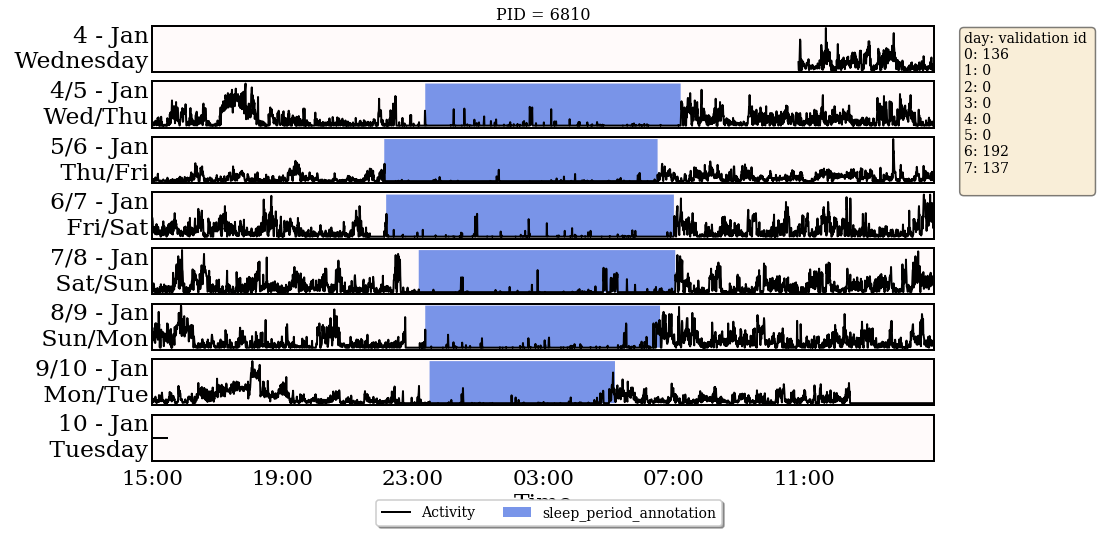

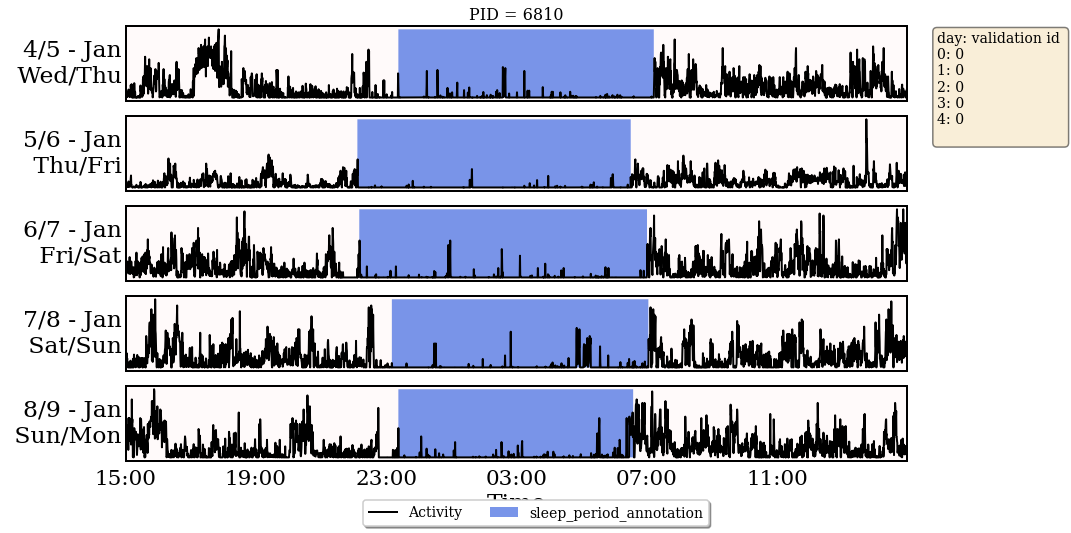

Removed 0 wearables.
Removed 3 days that are not consecutive.
Removed 0 wearables.
Changing experiment_day representation to ml_sequence


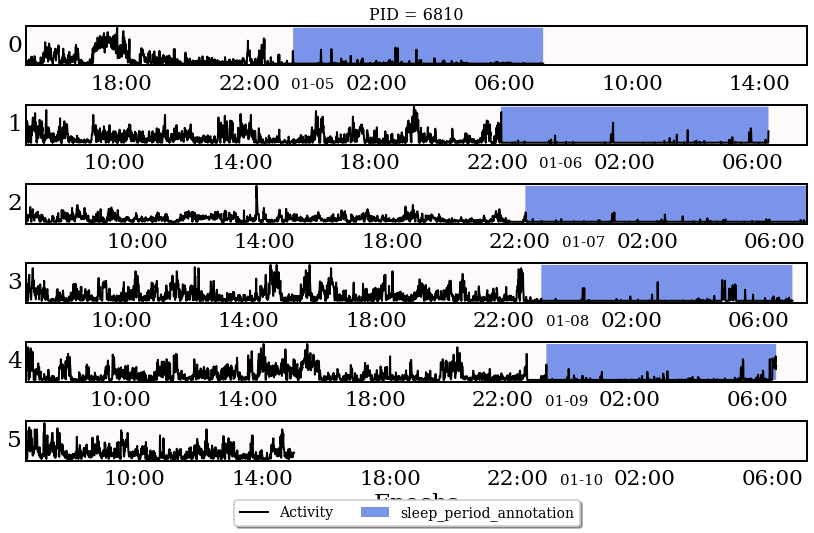

Total number of wearables: 1
Total number of days: 6
Avg. number of days: 6.00 (+-0.000). Max: 6, Min: 6.
Avg. number of epochs: 14400.00 (+-0.000). Max: 14400, Min: 14400.


In [11]:
investigate_one_wearable('6810')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:40: UserWarning: Day has no valid elements for column hyp_sleep_candidate.


Total number of wearables: 1
Total number of days: 9
Avg. number of days: 9.00 (+-0.000). Max: 9, Min: 9.
Avg. number of epochs: 22901.00 (+-0.000). Max: 22901, Min: 22901.
Sleep Boundary Detector...
Number of days removed due to InvCode.FLAG_DAY_SHORT_SLEEP: 2
Number of days removed due to InvCode.FLAG_DAY_LONG_SLEEP: 0
Number of days removed due to InvCode.FLAG_DAY_WITHOUT_DIARY: 0
Number of days removed due to InvCode.FLAG_DAY_NON_WEARING: 4
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_VALID_EPOCHS: 4
Number of days removed due to InvCode.FLAG_DAY_NOT_ENOUGH_CONSECUTIVE_DAYS: 0
Total number of potential days to remove (may have overlaps): 10


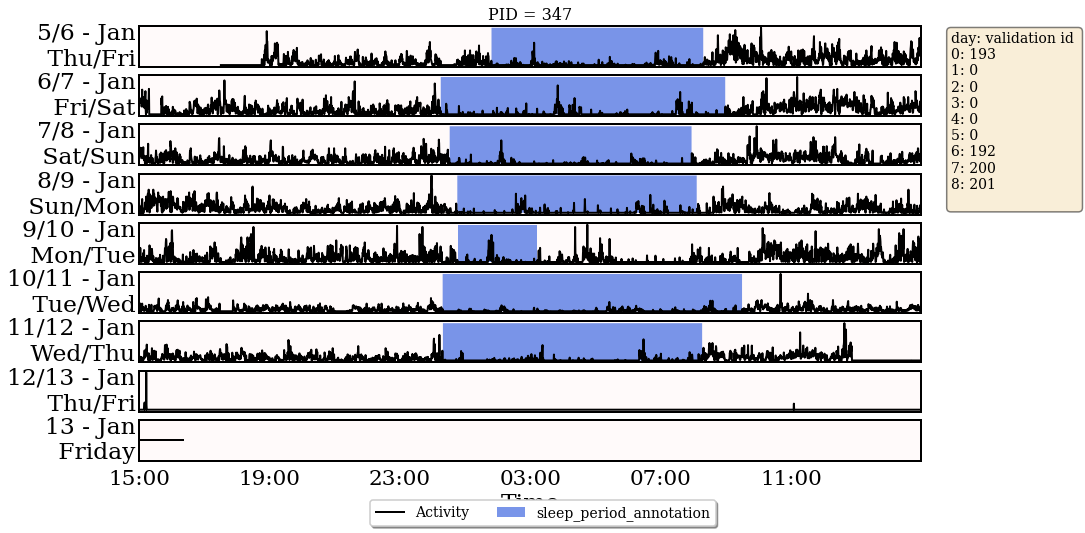

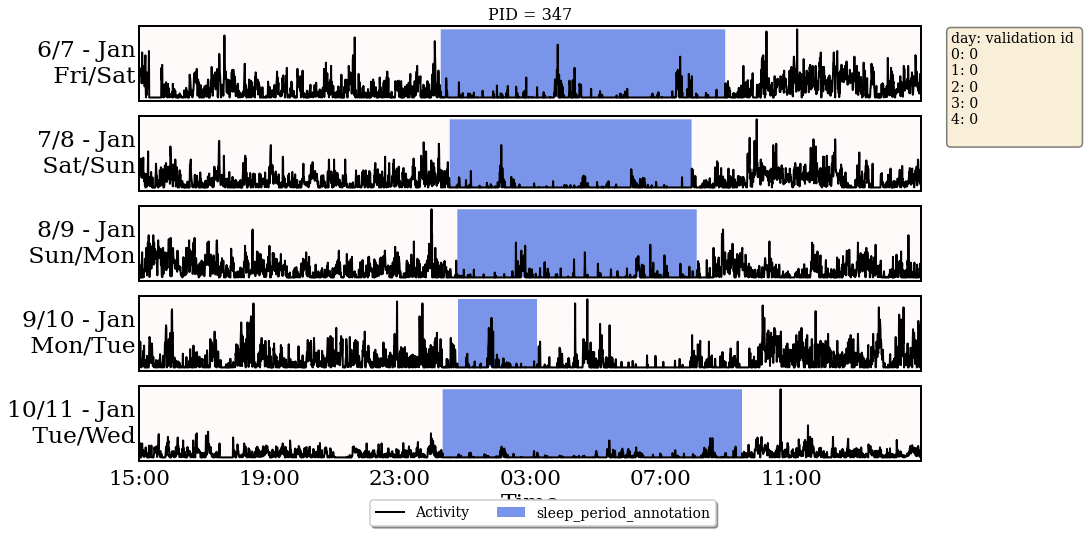

Removed 0 wearables.
Removed 4 days that are not consecutive.
Removed 0 wearables.
Changing experiment_day representation to ml_sequence


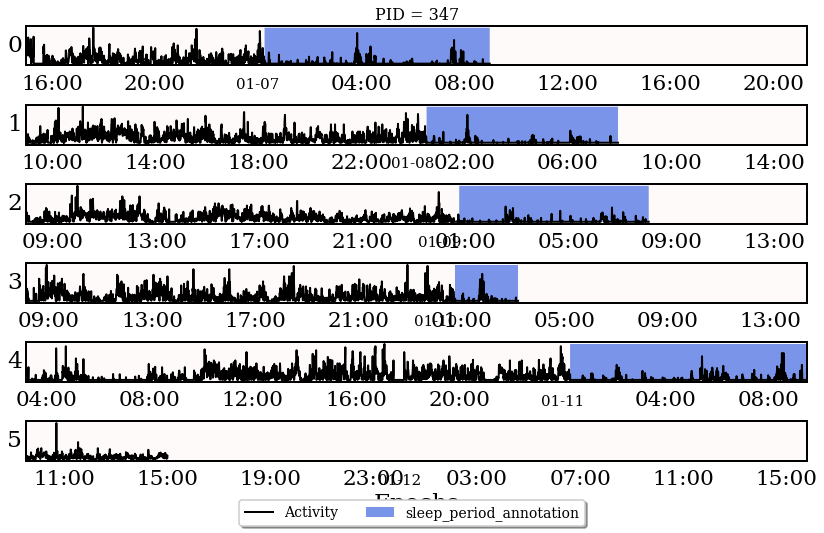

Total number of wearables: 1
Total number of days: 6
Avg. number of days: 6.00 (+-0.000). Max: 6, Min: 6.
Avg. number of epochs: 14400.00 (+-0.000). Max: 14400, Min: 14400.


In [14]:
investigate_one_wearable('0347')

# Physical Activity <a id='physical_activity'></a>

In [6]:

print("Calculating PA features")
pa_levels = ["sedentary", "light", "medium", "vigorous"]
value_vars = []

pa = PhysicalActivity(exp)
# METS: 1.5, 3, 6
pa.set_cutoffs(cutoffs=[58, 399, 1404], names=pa_levels)
pa.generate_pa_columns(based_on="activity")
bouts = []
for act_level in pa_levels:
    print(act_level)
    tmp_list = []
    for length in [5, 10, 15, 20]:
        tmp_list.append(pa.get_bouts(act_level, length, length // 2,
                                     resolution="hour", sleep_col="sleep_period_annotation"))
    tmp_list = pd.concat(tmp_list)
    if not tmp_list.empty:
        value_vars.append(act_level)
        bouts.append(tmp_list)

# Merge PA datasets
bouts = functools.reduce(
    lambda left, right: pd.merge(left, right, on=["pid", exp_day_column, "hyp_time_col", "bout_length"],
                                 how='outer'), bouts).fillna(0.0)

print('-------Done getting bouts--------')

# bouts_melted = bouts.melt(id_vars=["pid", exp_day_column, "bout_length"],
#                           value_vars=value_vars)

bouts['hyp_time_col'] = pd.Categorical(bouts['hyp_time_col'], ordered=True, categories=range(24))
# Make sure that this wont happen
bouts = bouts[bouts[exp_day_column] != -1]

# TODO: bouts_per_hour need to be saved as well
bouts_per_hour = bouts.groupby(['pid', exp_day_column, 'hyp_time_col', 'bout_length'])[value_vars].mean().fillna(0)

bouts_per_day = bouts_per_hour.groupby(['pid', exp_day_column, 'bout_length']).sum() # Total number of bouts per day
bouts_per_day = bouts_per_day.pivot_table(index=['pid', exp_day_column],
                                          columns=['bout_length'],
                                          values=value_vars)
# Flatten hierarchical column names
bouts_per_day.columns = ['_'.join(map(str, col)).strip() for col in bouts_per_day.columns.values]

pa_bins = pa.get_binned_pa_representation()
pa_bins_per_hour = pa_bins.pivot_table(index=['pid', exp_day_column, "hyp_time_col"])
pa_bins_per_day = pa_bins.pivot_table(index=['pid', exp_day_column])

pa_stats = pa.get_stats_pa_representation()
pa_stats_per_hour = pa_stats.pivot_table(index=['pid', exp_day_column, "hyp_time_col"])
pa_stats_per_day = pa_stats.pivot_table(index=['pid', exp_day_column])

pa_raw_per_hour = pa.get_raw_pa("hour")
pa_raw_per_hour = pa_raw_per_hour.set_index(['pid', exp_day_column, "hyp_time_col"])
#pa_raw_per_hour["raw_pa"] = pa_raw_per_hour["raw_pa"].apply(lambda x: ','.join(x.astype(str)))

pa_raw_per_day = pa.get_raw_pa("day")
pa_raw_per_day = pa_raw_per_day.set_index(['pid', exp_day_column])
pa_raw_per_day["raw_pa"] = pa_raw_per_day["raw_pa"].apply(lambda x: ','.join(x.astype(str)))

elapsed_time = check_time(elapsed_time)
print("Done with PA features...")

# Sleep Analysis
print("Calculating Sleep Metrics")
sm = SleepMetrics(exp)
sleep_metrics = ["sleepEfficiency", "totalSleepTime"]
sleep_metrics_per_day = []
for sleep_metric in sleep_metrics:
    sleep_metrics_per_day.append(sm.get_sleep_quality(sleep_metric=sleep_metric, wake_sleep_col="sleep",
                                                      sleep_period_col="sleep_period_annotation"))

sleep_metrics.append("awakening")
sleep_metrics_per_day.append(sm.get_sleep_quality(sleep_metric="awakening", wake_sleep_col="sleep",
                                                  ignore_awakenings_smaller_than_X_minutes=5,
                                                  sleep_period_col="sleep_period_annotation"))

# SRI calculation will not work with set_ml_representation_days_exp because day representation will be of different lengths.
# While SRI requires the days to be of fixed lengths.
# sleep_metrics.append("sri")
# sleep_metrics.append(sm.get_sleep_quality(sleep_metric="sri", wake_sleep_col="sleep"))

sleep_metrics_per_day = functools.reduce(
    lambda left, right: pd.merge(left, right, on=["pid", exp_day_column], how='outer'),
    sleep_metrics_per_day)
sleep_metrics_per_day = sleep_metrics_per_day.set_index(['pid', 'ml_sequence'])[sleep_metrics]

elapsed_time = check_time(elapsed_time)
print("Done with sleep metrics...")

# Circadian Analysis
print("Running Circadian Analysis")
ca = CircadianAnalysis(exp)

cosinor_keys = ["amplitude", "acrophase", "mesor"]
cosinor_per_day = ca.run_cosinor()
cosinor_per_day = cosinor_per_day[cosinor_keys]

elapsed_time = check_time(elapsed_time)
print("Done with circadian features...")


Calculating PA features
sedentary
light
medium
vigorous


c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:82: UserWarning: Could not find any valid sequence. Aborting.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:82: UserWarning: Could not find any valid sequence. Aborting.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:82: UserWarning: Could not find any valid sequence. Aborting.
c:\development\projects\sleep\sleep\lib\site-packages\hypnospy-0.0.4-py3.7.egg\hypnospy\misc.py:82: UserWarning: Could not find any valid sequence. Aborting.


-------Done getting bouts--------
Elapsed 77.8 sec (=1.30 min):
Done with PA features...
Calculating Sleep Metrics


2it [00:00, 11.78it/s]

Elapsed 0.2 sec (=0.00 min):
Done with sleep metrics...
Running Circadian Analysis


4it [00:00, 11.80it/s]

Elapsed 0.3 sec (=0.01 min):
Done with circadian features...


# Demographics <a id='demographics'></a>

In [7]:

# SSA is not yet ready to be used.
ssa = ca.run_SSA()
print("Calculating Demographic features")
demo = Demographics(file_path=path_to_demographics, pid_col=pid_col, save_only_cols=variables,
                    clock_features=clock_variables, dtype=None)
demo.data = demo.data.replace("S", np.nan).replace("Q", np.nan)
for col in demo.data.keys():
    demo.data[col] = demo.data[col].astype(np.float)

elapsed_time = check_time(elapsed_time)
print("Done with demographic features...")

# Time related features
print("Calculating Time related features")
weekend = exp.is_weekend()
weekday = exp.weekday()
time_features_per_day = pd.merge(weekend, weekday).set_index(["pid", exp_day_column])

elapsed_time = check_time(elapsed_time)
print("Done with time features...")


0it [00:00, ?it/s]

=== Running SSA ===
0
(5761, 1440)


  0%|                                                                                 | 1/1440 [00:00<03:52,  6.19it/s]

input: (5761, 1440)
U: (5761, 5761)
s: (1440,)
V: (1440, 1440)
r: 1440
gkList: (1440, 7200)


100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [04:09<00:00,  5.78it/s]
1it [05:02, 302.08s/it]

1
(7247, 1440)


  0%|                                                                                         | 0/1440 [00:00<?, ?it/s]

input: (7247, 1440)
U: (7247, 7247)
s: (1440,)
V: (1440, 1440)
r: 1440
gkList: (1440, 8686)


100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [05:09<00:00,  4.65it/s]
2it [11:16, 344.72s/it]

2
(7219, 1440)


  0%|                                                                                         | 0/1440 [00:00<?, ?it/s]

input: (7219, 1440)
U: (7219, 7219)
s: (1440,)
V: (1440, 1440)
r: 1440
gkList: (1440, 8658)


100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [06:46<00:00,  3.54it/s]
3it [19:07, 402.15s/it]

3
(5795, 1440)


  0%|                                                                                 | 1/1440 [00:00<04:06,  5.83it/s]

input: (5795, 1440)
U: (5795, 5795)
s: (1440,)
V: (1440, 1440)
r: 1440
gkList: (1440, 7234)


100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [04:11<00:00,  5.73it/s]
4it [24:11, 362.83s/it]


Calculating Demographic features


c:\development\projects\sleep\sleep\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (118,119,121,125,145,181,184,186,257,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,529,999,1006,1007,1014,1026,1027,1028,1029,1031,1032,1033,1043,1049) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Elapsed 1897.4 sec (=31.62 min):
Done with demographic features...
Calculating Time related features
Elapsed 0.0 sec (=0.00 min):
Done with time features...


In [8]:


day_keys = {"bins": list(pa_bins_per_day.keys()),
           "bouts": list(bouts_per_day.keys()),
           "stats": list(pa_stats_per_day.keys()),
           "raw": list(pa_raw_per_day.keys()),
           "sleep_metrics": sleep_metrics,
           "cosinor": cosinor_keys,
           "time": ["hyp_weekday", "hyp_is_weekend"]
           }

print("Merging representations")
data_representation_per_day = pd.merge(bouts_per_day, pa_bins_per_day, left_index=True, right_index=True).merge(
    pa_stats_per_day, left_index=True, right_index=True).merge(
    pa_raw_per_day, left_index=True, right_index=True).merge(
    sleep_metrics_per_day, left_index=True, right_index=True).merge(
    cosinor_per_day, left_index=True, right_index=True)
#.merge(
#    time_features_per_day, left_index=True, right_index=True
#)

data_representation_per_hour = pd.merge(bouts_per_hour, pa_bins_per_hour, left_index=True, right_index=True,
                                        suffixes=("_bouts", "_bins")).merge(
    pa_stats_per_hour, left_index=True, right_index=True).merge(
    pa_raw_per_hour, left_index=True, right_index=True
)
data_representation_per_pid = demo.get_valid_data_for_experiment(exp)

data_representation_per_day.to_csv("%s_per_day.csv" % DATA_COLLECTION)
data_representation_per_hour.to_csv("%s_per_hour.csv" % DATA_COLLECTION)
data_representation_per_pid.to_csv("%s_per_pid.csv" % DATA_COLLECTION)
day_keys = pd.Series(day_keys)
day_keys.index.name = "key"
day_keys.name = "value"
day_keys.to_csv("%s_day_keys.csv" % DATA_COLLECTION)

pd.Series(data_representation_per_day.reset_index()["pid"].unique(), name="pids").to_csv("%s_pid.csv" % DATA_COLLECTION, index=False)

check_time(start)
print("Done with all...")


Merging representations
Elapsed 1980.7 sec (=33.01 min):
Done with all...


# Investigate ml format sequence length <a id='sequence_length'></a>

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def wearable_get_ml_sequence_list(w):
    return w.data.groupby('ml_sequence')['hyp_act_x'].apply(list)

def wearable_get_ml_sequence_len(w):
    return w.data.groupby('ml_sequence')['hyp_act_x'].apply(len)

def get_ml_sequence_list(exp):
    ml_sequence_list = []
    for w in exp.get_all_wearables():
        wearable_ml_sequence = wearable_get_ml_sequence_list(w)
        wearable_ml_sequence_list = pd.DataFrame(wearable_ml_sequence_len).reset_index()
        wearable_ml_sequence_list['pid'] = w.get_pid()
        wearable_ml_sequence_list = wearable_ml_sequence_list[['pid', 'ml_sequence', 'hyp_act_x']]
        wearable_ml_sequence_list.columns = ['pid', 'ml_sequence', 'list']
        wearable_ml_sequence_list.set_index('pid')
        ml_sequence_list.append(wearable_ml_sequence_list)
    
    ml_sequence_list = pd.concat(ml_sequence_list)
    ml_sequence_list = ml_sequence_list.set_index('pid')
    return ml_sequence_list

def get_ml_sequence_len(exp):
    ml_sequence_len = []
    for w in exp.get_all_wearables():
        wearable_ml_sequence_len = wearable_get_ml_sequence_len(w)
        wearable_ml_sequence_len = pd.DataFrame(wearable_ml_sequence_len).reset_index()
        wearable_ml_sequence_len['pid'] = w.get_pid()
        wearable_ml_sequence_len = wearable_ml_sequence_len[['pid', 'ml_sequence', 'hyp_act_x']]
        wearable_ml_sequence_len.columns = ['pid', 'ml_sequence', 'len']
        ml_sequence_len.append(wearable_ml_sequence_len)
    
    ml_sequence_len = pd.concat(ml_sequence_len)
    ml_sequence_len = ml_sequence_len.set_index('pid')
    return ml_sequence_len

# wearable_get_ml_sequence_len(w0)

In [48]:
sequences_length = get_ml_sequence_len(exp)

count    1187.000000
mean        4.421230
std         0.647596
min         4.000000
25%         4.000000
50%         4.000000
75%         5.000000
max        10.000000
Name: ml_sequence, dtype: float64
count    5248.000000
mean     2886.300114
std       170.053697
min      2401.000000
25%      2796.000000
50%      2882.000000
75%      2967.000000
max      4505.000000
Name: len, dtype: float64


<AxesSubplot:ylabel='Density'>

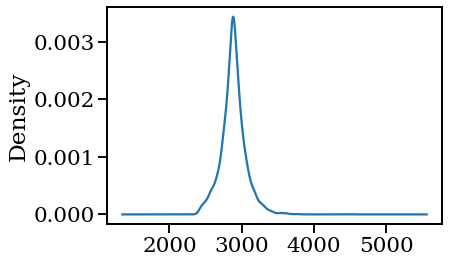

In [63]:
print(sequences_length.groupby('pid')['ml_sequence'].count().describe())
print('==========')
print(sequences_length['len'].describe())
sequences_length['len'].plot.density()